# Import Packages

In [17]:
import kagglehub
import pandas as pd
import os
from PIL import Image
import numpy as np
import torch 
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim.lr_scheduler as lrSched  # To change learning rate
from sklearn.decomposition import PCA



# EDA


In [18]:
# Download latest version
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)

# Load the dataset into a pandas DataFrame
csv_file_path = f"{path}/chinese_mnist.csv"
dataDF = pd.read_csv(csv_file_path)


# Print the feature names (column names)
print("Feature names:", dataDF.columns.tolist())

Path to dataset files: /home/ajz004/.cache/kagglehub/datasets/gpreda/chinese-mnist/versions/7
Feature names: ['suite_id', 'sample_id', 'code', 'value', 'character']


In [19]:
IMAGE_PATH = f"{path}/data/data/"
print("image files :", len(os.listdir(IMAGE_PATH)))

# Add file name to the data frame
dataDF['file'] = dataDF[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataDF.head(5)

# Characters list
characters = dataDF['character'].unique().tolist()
print(characters)
print(len(characters))

codes = dataDF['code'].unique().tolist()
print(codes)
print(len(codes))

dataDF.groupby(["code","character"]).size()

OUTPUT_SIZE = len(codes)

image files : 15000
['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
15
[10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9]
15


In [20]:
indexImage = 3000
imgPath =  os.path.join(IMAGE_PATH, dataDF['file'][indexImage]) 
im = Image.open(imgPath)
im.size
IMG_SIZE = im.size[0]

## Data Preparation

In [21]:
class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir):
        self.df = annotations_dataframe
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath =  os.path.join(self.img_dir, self.df ['file'][idx]) 
        img = Image.open(imgPath)

        imgAsT = torch.from_numpy(np.array(img)).float()

        label = self.df['code'][idx] -1 # let's use the code as target variable
        
        return imgAsT, label

In [22]:
chineseNumbers = ChineseMNISTdataset(dataDF, IMAGE_PATH)  # init
chineseNumbers.__len__() # dataset length

15000

torch.Size([64, 64])
9
15000


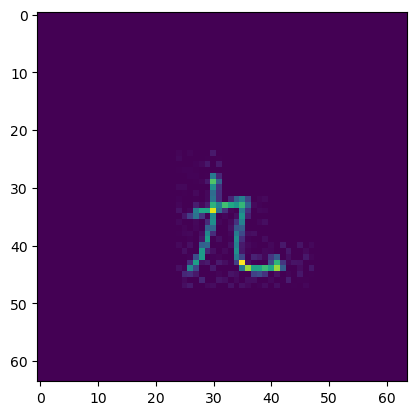

In [23]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)
plt.imshow(img)
print(len(chineseNumbers))




## Split data for training and testing

In [24]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [25]:
testSize = chineseNumbers.__len__() // 10
trainSize = chineseNumbers.__len__() - testSize

trainDataset, testDataset = random_split(chineseNumbers, [trainSize, testSize])

len(trainDataset), len(testDataset)

(13500, 1500)

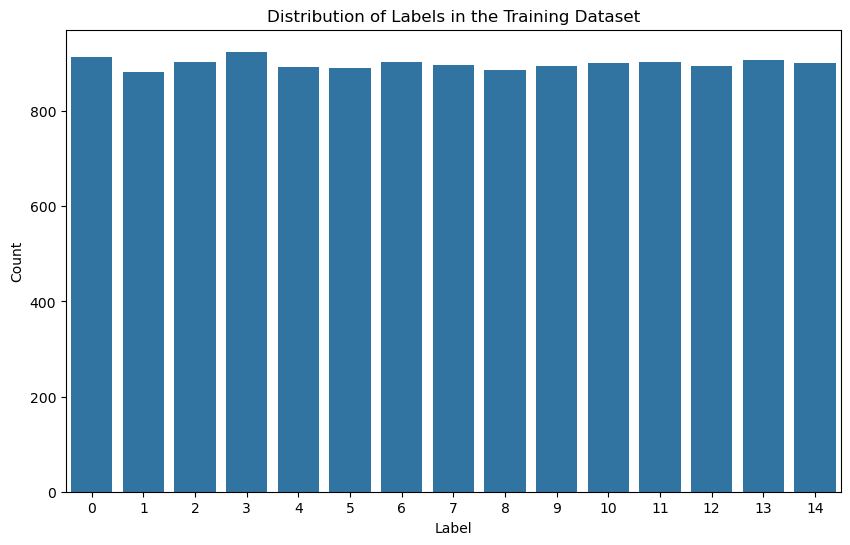

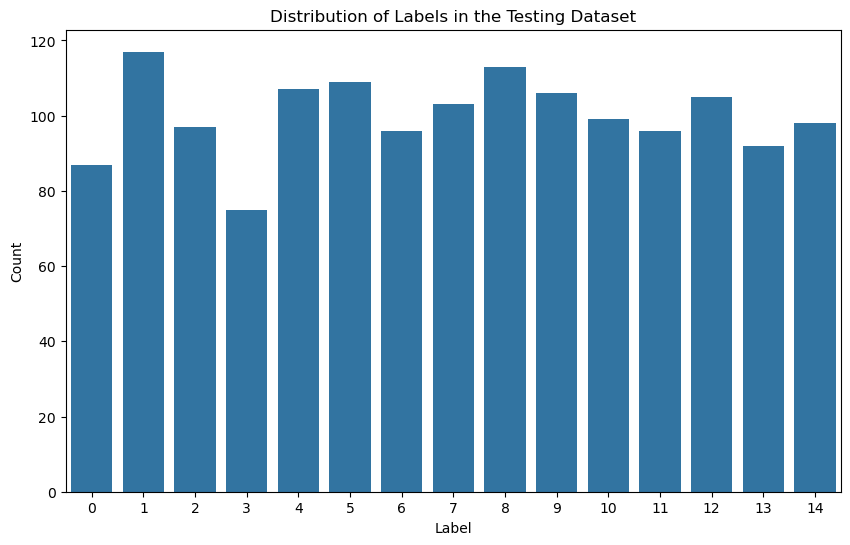

In [26]:
# Extract labels from the training dataset
train_labels = [trainDataset[i][1] for i in range(len(trainDataset))]

# Convert training labels to a pandas DataFrame
train_labels_df = pd.DataFrame(train_labels, columns=['label'])

# Extract labels from the testing dataset
test_labels = [testDataset[i][1] for i in range(len(testDataset))]

# Convert testing labels to a pandas DataFrame
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Visualize the distribution of the labels for the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_labels_df)
plt.title('Distribution of Labels in the Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of the labels for the testing dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=test_labels_df)
plt.title('Distribution of Labels in the Testing Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [27]:
labels_dict = {
     0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5",
     6: "6", 7: "7", 8: "8", 9: "9", 10: "10",
     11: "100", 12: "1000", 13: "10,000", 14: "1,000,000"
 }


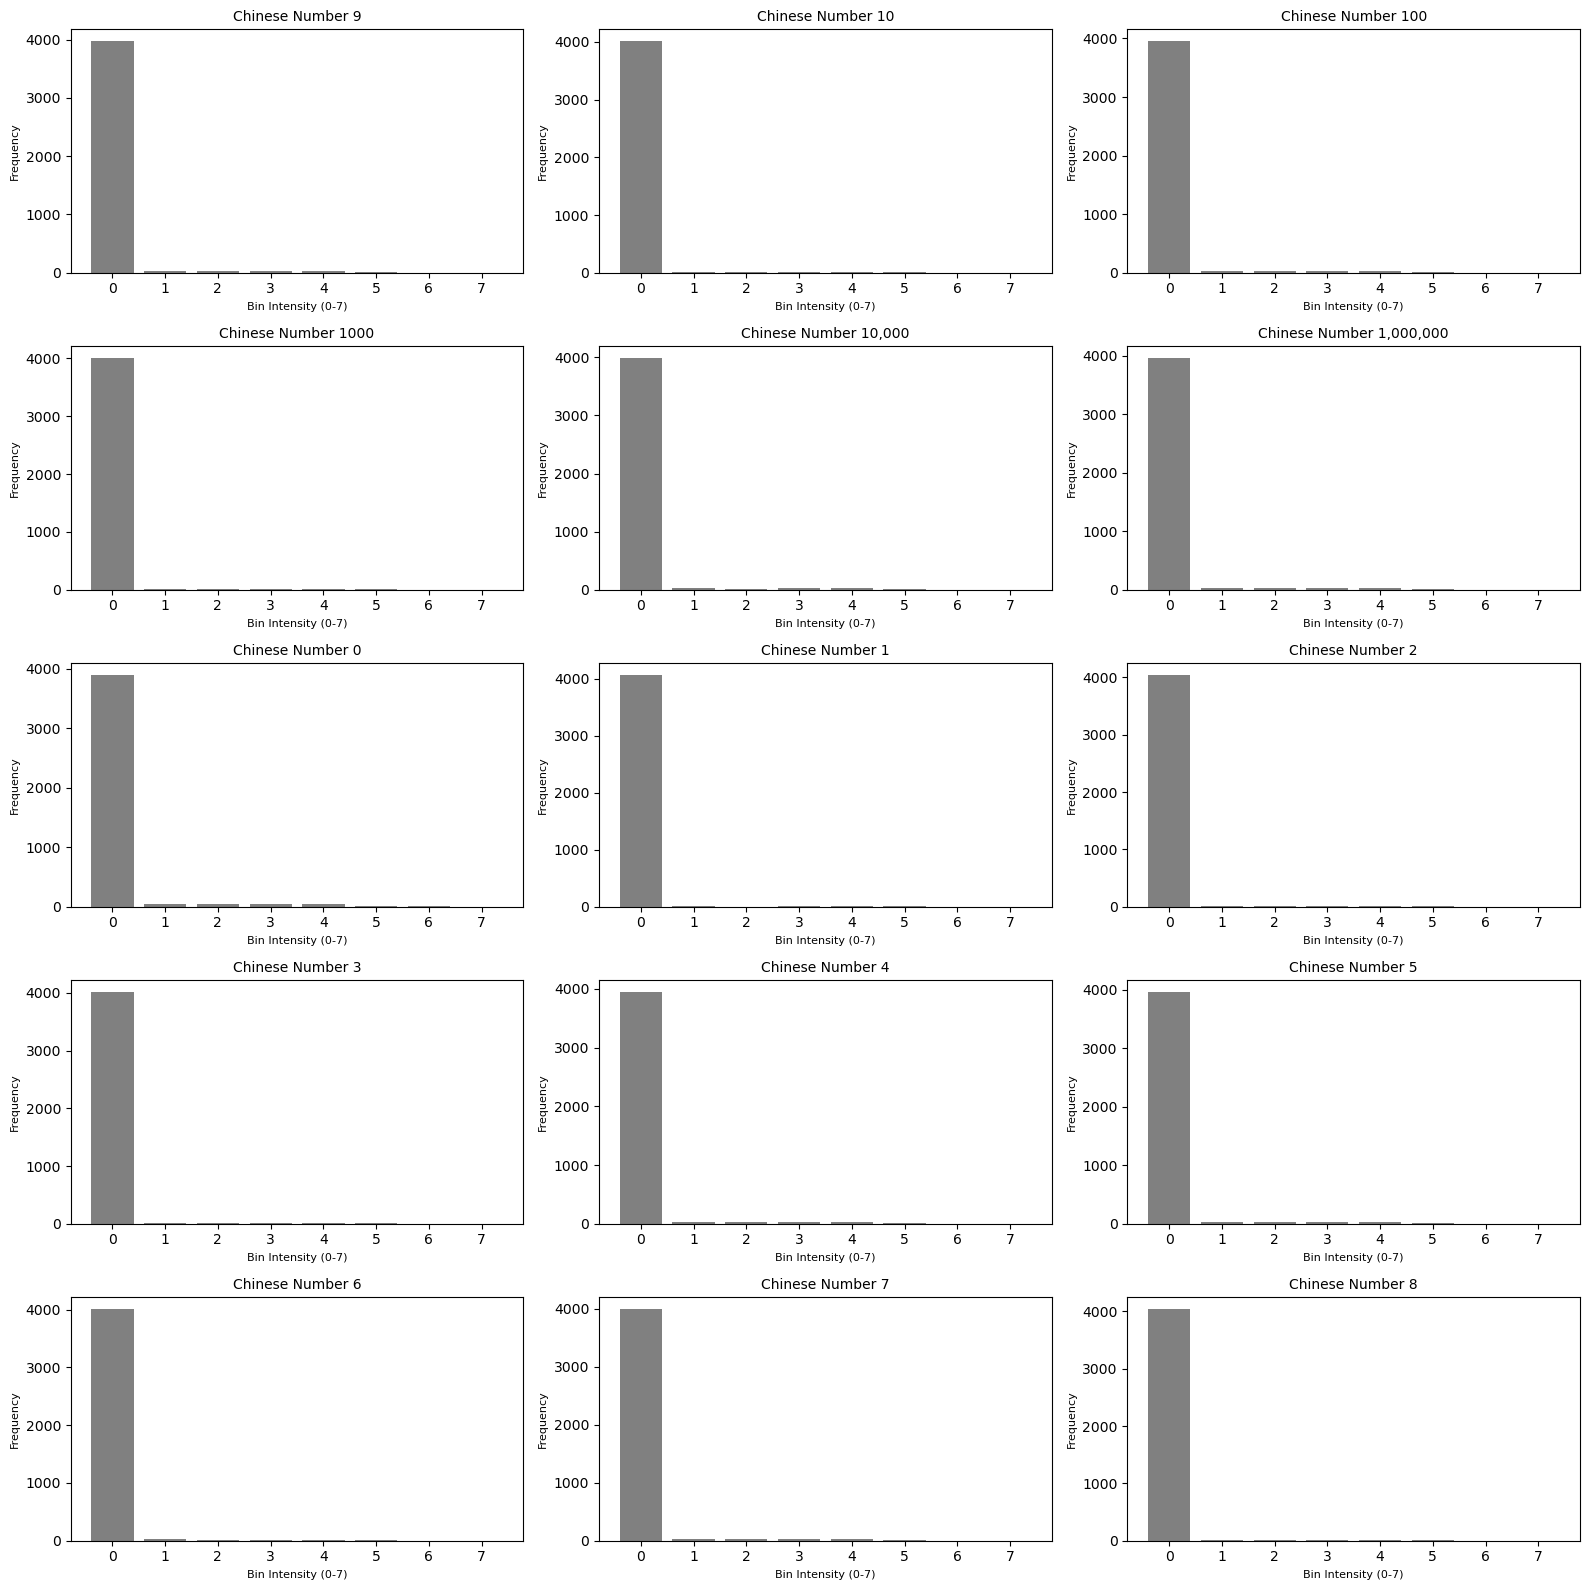

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of rows and columns for subplots
rows = 5
cols = 3 
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))  
axes = axes.flatten()  # Flatten the axes for easier indexing in a 1D array

for idx, i in enumerate(range(0, 15000, 1000)):
    if idx >= len(axes):  
        break

    accumulated_hist = np.zeros(8)

    # Accumulate histogram for 10 images starting from each `i` value
    for j in range(i, i + 10):
        img, label = chineseNumbers.__getitem__(j)  # Get the numpy array for each image

        # Flatten the array to 1D for histogram calculation
        img_array = img.flatten()  # Flatten to ensure 1D array for histogram

        # Calculate the histogram with 8 bins over the full range of 0 to 255
        hist, _ = np.histogram(img_array, bins=8, range=(0, 256))
        accumulated_hist += hist / 10  # Calculate average histogram per image

    # Plot the accumulated histogram in the appropriate subplot
    axes[idx].bar(range(8), accumulated_hist, color='gray', tick_label=range(8))
    axes[idx].set_xlabel('Bin Intensity (0-7)', fontsize=8)
    axes[idx].set_ylabel('Frequency', fontsize=8)
    axes[idx].set_title(f'Chinese Number {labels_dict[label]}', fontsize=10)

# Hide any unused subplots
for idx in range(len(axes)):
    if idx >= (15000 // 1000):  # Number of histograms generated
        axes[idx].axis('off')  # Turn off unused subplots

# Adjust layout and display
plt.tight_layout()
plt.show()


## Sharpness and Edge Detection
- **Objective**: To detect inconsistencies in stroke sharpness and identify blurry or low-quality scans.
- **How**: Apply edge detection filters (such as Sobel or Canny) across a random subset of images. Calculate edge sharpness metrics, and examine if there’s a wide variance in edge clarity.
- **Outcome**: Reveals if any images may need filtering or quality adjustments to standardize sharpness, ensuring the model doesn’t learn unintended noise.

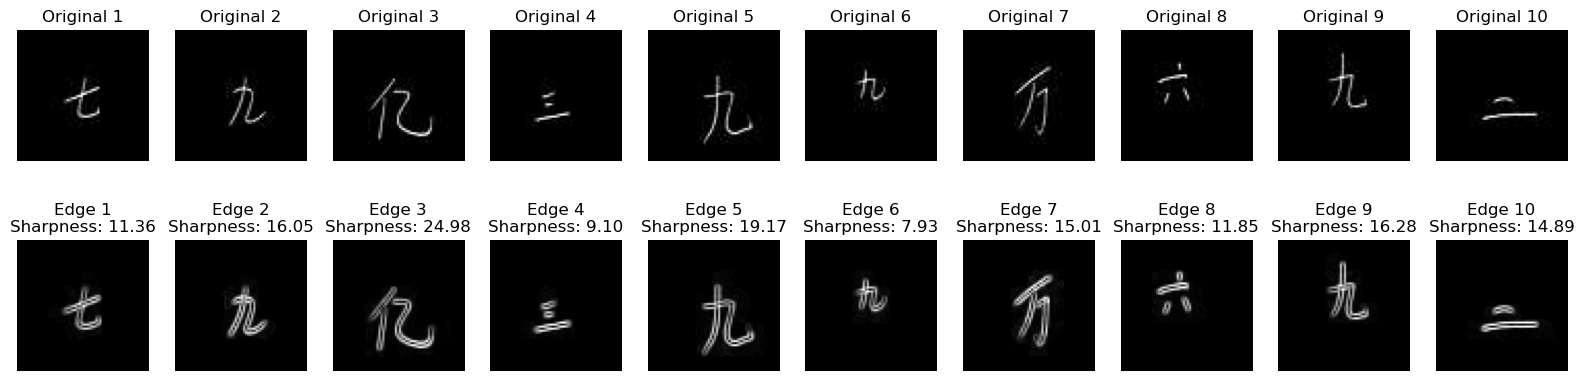

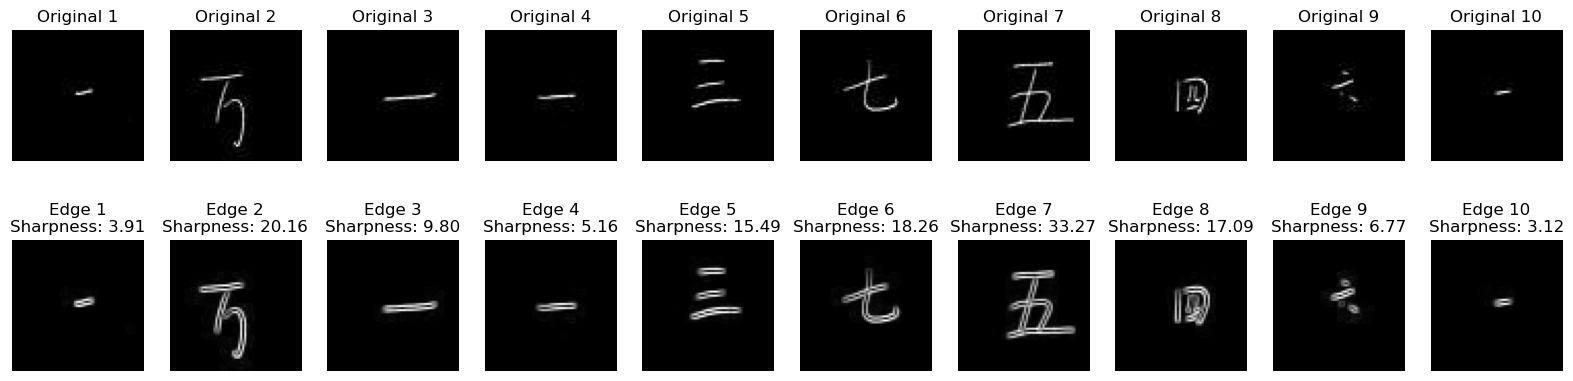

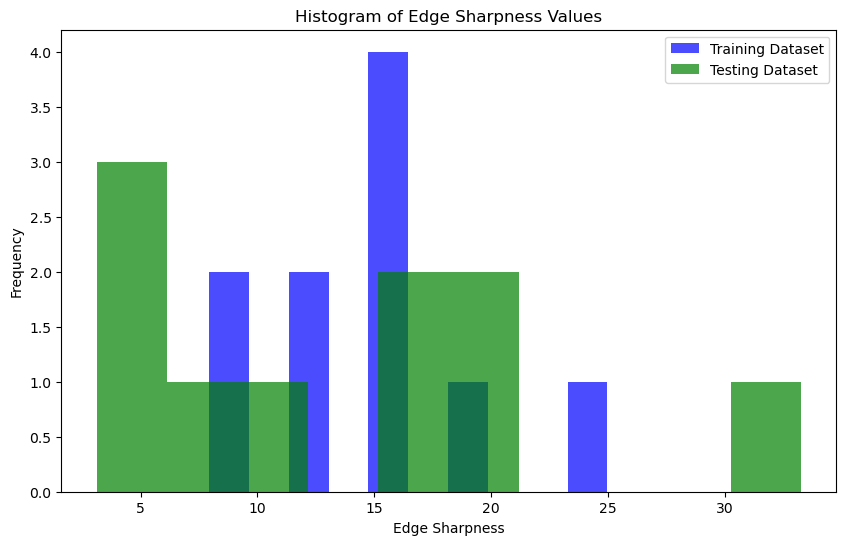

In [44]:
from scipy.ndimage import sobel



# Function to apply Sobel filter and calculate edge sharpness
def calculate_edge_sharpness(image):
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    edge_magnitude = np.hypot(sobel_x, sobel_y)
    return np.mean(edge_magnitude)

# Function to visualize edge detection on a random subset of images
def visualize_edge_detection(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    
    sharpness_values = []
    
    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img_np = img.numpy()
        
        # Calculate edge sharpness
        sharpness = calculate_edge_sharpness(img_np)
        sharpness_values.append(sharpness)
        
        # Plot original image
        axes[0, i].imshow(img_np, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        # Plot edge detection result
        sobel_x = sobel(img_np, axis=0)
        sobel_y = sobel(img_np, axis=1)
        edge_magnitude = np.hypot(sobel_x, sobel_y)
        axes[1, i].imshow(edge_magnitude, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Edge {i+1}\nSharpness: {sharpness:.2f}')
    
    plt.show()
    
    return sharpness_values

# Visualize edge detection on a random subset of training images
train_sharpness_values = visualize_edge_detection(trainDataset)

# Visualize edge detection on a random subset of testing images
test_sharpness_values = visualize_edge_detection(testDataset)

# Plot histogram of sharpness values for training and testing datasets
plt.figure(figsize=(10, 6))
plt.hist(train_sharpness_values, bins=10, color='blue', alpha=0.7, label='Training Dataset')
plt.hist(test_sharpness_values, bins=10, color='green', alpha=0.7, label='Testing Dataset')
plt.title('Histogram of Edge Sharpness Values')
plt.xlabel('Edge Sharpness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Intra-Character Consistency Check
- **Objective**: To examine the consistency of each character’s appearance across different samples and volunteers.
- **How**: Calculate the mean and standard deviation of pixel intensities for each character across all samples, visualizing the range to observe consistency. You might also create "mean" images for each character by averaging pixel values across all samples of a character.
- **Outcome**: This shows the typical appearance of each character and helps in understanding how much variation exists within the same character, which is useful for designing augmentations.

In [45]:

mean_images = []
st_dev_images = []
titles = []

# Loop through each character in the dataset
for character in range(len(characters)):
    character_img = []

# Gather all images for the character in training dataset
    for i in range(len(trainDataset)):
        img, label = trainDataset[i]
        if label == character:
            character_img.append(img.numpy())

    # Skip if no images found for this character
    if len(character_img) == 0:
        print(f"No images found for character {character}")
        continue

    # Convert list of images to 3D numpy array (num_samples, height, width)
    character_img = np.array(character_img)

    # Calculate mean and standard deviation across the sample dimension
    mean_image = np.mean(character_img, axis=0)
    st_dev_image = np.std(character_img, axis=0)

    # Save mean and std images for this character and titles for each
    mean_images.append(mean_image)
    st_dev_images.append(st_dev_image)
    titles.append(f"{character} Mean")
    titles.append(f"{character} Std Dev")


# Plot all images in a grid
num_images = len(mean_images) + len(st_dev_images)
cols = 8  # Grid dimensions
rows = (num_images + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.ravel()

# Check axes for all images
for i, ax in enumerate(axes):
    if i < len(titles):
        if i % 2 == 0:
            ax.imshow(mean_images[i // 2], cmap='gray')
        else:
            ax.imshow(st_dev_images[i // 2], cmap='hot')
        ax.set_title(titles[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused axes

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

# Data Preparation

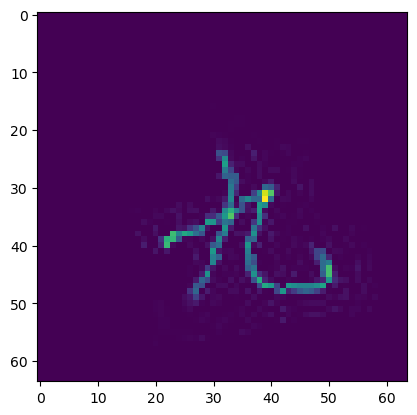

In [ ]:
# demonstration of random rotation on single image

img, label = chineseNumbers.__getitem__(123)
plt.imshow(img)
img_pil = Image.fromarray(img.numpy().astype(np.uint8))
random_rotation = transforms.RandomRotation(degrees=(-30, 30))
rotated_img = random_rotation(img_pil)
plt.imshow(rotated_img)


## Character Pattern Analysis Using PCA
Objective: To identify structural patterns in characters and see if they’re distinguishable based on strokes and shapes.
How: Flatten each image and apply Principal Component Analysis (PCA) on these flattened images for each character. Plot the first two principal components to visualize common patterns or traits within each character class.
Outcome: This helps uncover distinctive patterns or shapes for each character, providing insights into feature extraction needs for classification.



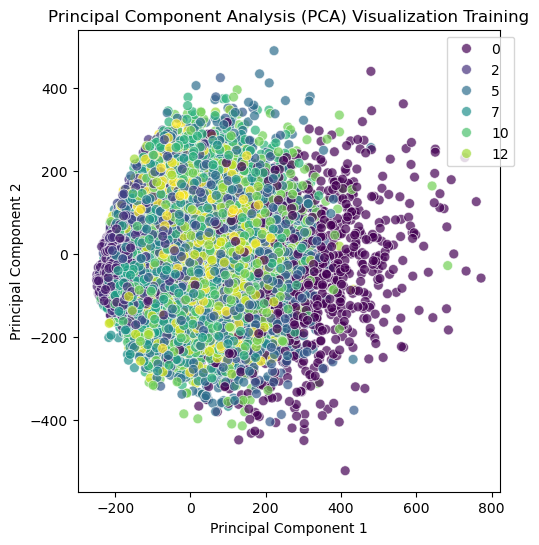

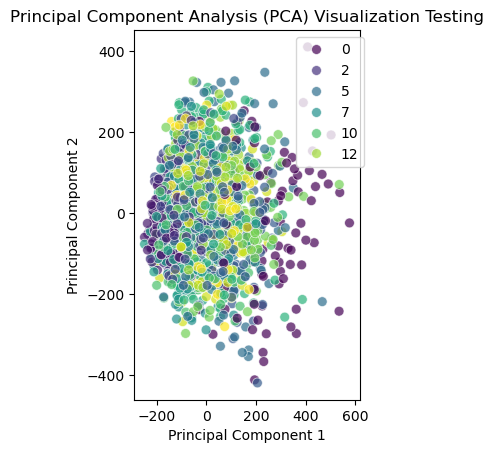

<Figure size 640x480 with 0 Axes>

In [ ]:
def load_and_flatten_images(dataset):
  flattened_images = []
  labels = []

  for i in range(len(dataset)):
    img, label = dataset[i]
    img_np = img.numpy().flatten()
    flattened_images.append(img_np)
    labels.append(label)

  return np.array(flattened_images), np.array(labels)

train_flattened_images, labels = load_and_flatten_images(trainDataset)
test_flattened_images, _ = load_and_flatten_images(testDataset)

pca = PCA(n_components=2)
train_principal_components = pca.fit_transform(train_flattened_images)
test_principal_components = pca.transform(test_flattened_images)

train_pca_df = pd.DataFrame({
    'PC1': train_principal_components[:, 0],
    'PC2': train_principal_components[:, 1],
    'Label': train_labels
})

test_pca_df = pd.DataFrame({
    'PC1': test_principal_components[:, 0],
    'PC2': test_principal_components[:, 1],
    'Label': test_labels
})


plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Label', palette='viridis', s= 50, alpha = 0.7)
plt.title('Principal Component Analysis (PCA) Visualization Training')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

plt.subplot(1,2,2)
sns.scatterplot(data=test_pca_df, x='PC1', y='PC2', hue='Label', palette='viridis', s= 50, alpha = 0.7)
plt.title('Principal Component Analysis (PCA) Visualization Testing')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

plt.tight_layout()
plt.show()


## Augmentation Preview for Quality Assurance

- **Objective**: To assess the effect of augmentations on image quality and character integrity.
- **How**: Apply planned augmentations (rotations, scaling, translations) on a sample set of images and visually inspect them in a grid format for each character.
- **Outcome**: Ensures that augmentations preserve the integrity of each character, helping validate that these transformations won’t create distortions or unnatural examples for the model.


27000
3000
Combined Train Dataset - Sample 0: Image shape: torch.Size([1, 64, 64]), Label: 12
Combined Train Dataset - Sample 1: Image shape: torch.Size([1, 64, 64]), Label: 5
Combined Train Dataset - Sample 2: Image shape: torch.Size([1, 64, 64]), Label: 2
Combined Train Dataset - Sample 3: Image shape: torch.Size([1, 64, 64]), Label: 6
Combined Train Dataset - Sample 4: Image shape: torch.Size([1, 64, 64]), Label: 0
Combined Test Dataset - Sample 0: Image shape: torch.Size([1, 64, 64]), Label: 3
Combined Test Dataset - Sample 1: Image shape: torch.Size([1, 64, 64]), Label: 1
Combined Test Dataset - Sample 2: Image shape: torch.Size([1, 64, 64]), Label: 1
Combined Test Dataset - Sample 3: Image shape: torch.Size([1, 64, 64]), Label: 14
Combined Test Dataset - Sample 4: Image shape: torch.Size([1, 64, 64]), Label: 7


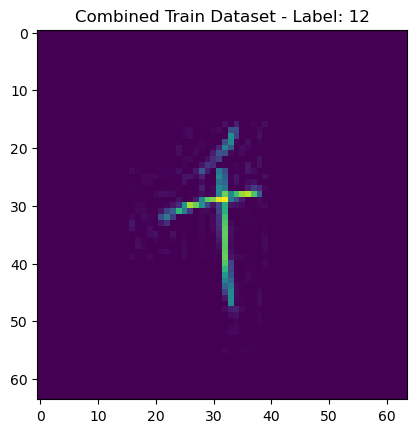

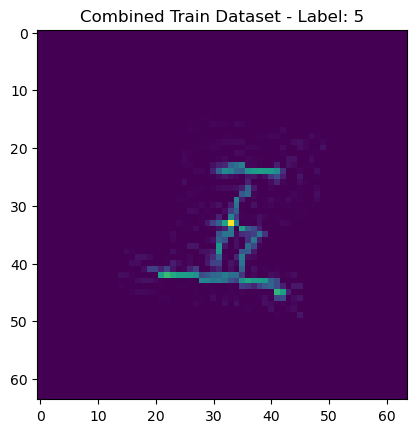

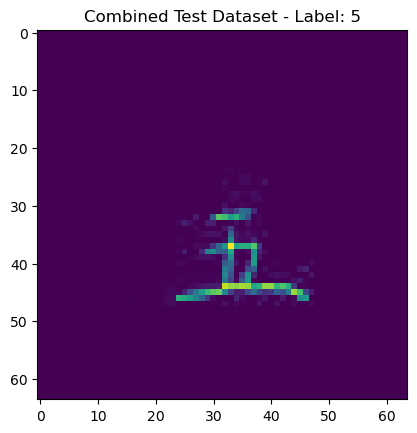

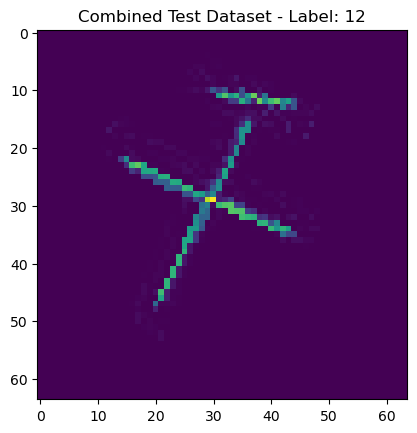

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def random_rotation(image):
    angle = random.uniform(-30, 30)  # Rotate between -30 and 30 degrees
    return image.rotate(angle)

# Assuming trainDataset and testDataset are already defined
augmented_images_train = []
augmented_labels_train = []
augmented_images_test = []
augmented_labels_test = []

# Convert original images to tensors with consistent shape
train_images_tensor = [transforms.ToTensor()(Image.fromarray(img.numpy().astype(np.uint8))) for img, _ in trainDataset]
test_images_tensor = [transforms.ToTensor()(Image.fromarray(img.numpy().astype(np.uint8))) for img, _ in testDataset]

for img, label in trainDataset:
    img_pil = Image.fromarray(img.numpy().astype(np.uint8))
    rotated_img = random_rotation(img_pil)
    rotated_img_tensor = transforms.ToTensor()(rotated_img)
    augmented_images_train.append(rotated_img_tensor)
    augmented_labels_train.append(label)

for img, label in testDataset:
    img_pil = Image.fromarray(img.numpy().astype(np.uint8))
    rotated_img = random_rotation(img_pil)
    rotated_img_tensor = transforms.ToTensor()(rotated_img)
    augmented_images_test.append(rotated_img_tensor)
    augmented_labels_test.append(label)

augmented_trainDataset = AugmentedDataset(augmented_images_train, augmented_labels_train)
augmented_testDataset = AugmentedDataset(augmented_images_test, augmented_labels_test)

combined_trainDataset = ConcatDataset([AugmentedDataset(train_images_tensor, [label for _, label in trainDataset]), augmented_trainDataset])
combined_testDataset = ConcatDataset([AugmentedDataset(test_images_tensor, [label for _, label in testDataset]), augmented_testDataset])

print(len(combined_trainDataset))
print(len(combined_testDataset))

# Check shapes and labels
def check_dataset_consistency(dataset, name):
    for i in range(5):  # Check 5 random samples
        img, label = dataset[random.randint(0, len(dataset) - 1)]
        print(f"{name} - Sample {i}: Image shape: {img.shape}, Label: {label}")

check_dataset_consistency(combined_trainDataset, "Combined Train Dataset")
check_dataset_consistency(combined_testDataset, "Combined Test Dataset")

# Visual inspection
def visualize_samples(dataset, name):
    for i in range(2):  # Visualize 3 random samples
        img, label = dataset[random.randint(0, len(dataset) - 1)]
        plt.imshow(transforms.ToPILImage()(img))
        plt.title(f"{name} - Label: {label}")
        plt.show()

visualize_samples(combined_trainDataset, "Combined Train Dataset")
visualize_samples(combined_testDataset, "Combined Test Dataset")

# Model Implementation
## VGG-16
### Define a data loader

### Define CNN model

In [113]:

class VGG16(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(VGG16, self).__init__()
        
        # Feature extraction layers (convolutional)
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # 1 input channel, 64 output channels
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Halve spatial dimensions
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 64 -> 128 channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 128 -> 256 channels
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 256 -> 512 channels
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 -> 512 channels
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected layers (classifier)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  # Flattened dimension: 512 * 2 * 2
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  # Dropout rate for regularization
            
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(4096, 15)  # Output layer with 15 classes
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)  # Convolutional layers
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.classifier(x)  # Fully connected layers
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [114]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

simpleModel = VGG16().to(device)
print("The model: ", simpleModel)

params = list(simpleModel.parameters())
len(params)

num_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
print("Total number of trainable model parameters:", num_params)

Using cuda device
The model:  VGG16(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inpl

### Train the model

In [115]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the hyperparameter grid
hyperparams = {
    'dropout_rate': [0.3, 0.5],          # Dropout rate to prevent overfitting
    'optimizer': ['SGD', 'Adam'],        # Optimizer type (SGD or Adam)
    'learning_rate': [0.001, 0.01],      # Learning rate
    'batch_size': [32, 64],              # Batch size
    'num_epochs': [20, 40],              # Number of epochs
    'regularization': [0.0001, 0.001]    # L2 regularization (weight decay) strength
}

# Generate all combinations of hyperparameters
grid = list(itertools.product(*hyperparams.values()))

# Placeholder to store the results
results = []

# Dataset and device
trainLoader = DataLoader(combined_trainDataset, batch_size=64, shuffle=True)
testLoader = DataLoader(combined_testDataset, batch_size=64, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to train and evaluate the model
def train_and_evaluate(params):
    # Unpack parameters
    dropout_rate, opt_type, lr, batch_size, num_epochs, reg = params

    # Adjust DataLoader for the batch size
    trainLoader = DataLoader(combined_trainDataset, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(combined_testDataset, batch_size=batch_size, shuffle=False)

    # Define the model
    model = VGG16(dropout_rate=dropout_rate)
    model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if opt_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)  # L2 Regularization
    elif opt_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)  # L2 Regularization

    # To store loss history
    loss_history = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for X, y in trainLoader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            logits = model(X)
            loss = criterion(logits, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            epoch_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        # Append loss for the current epoch to the loss history
        loss_history.append(epoch_loss / len(trainLoader))

        # Validation accuracy
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_val, y_val in testLoader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_logits = model(X_val)
                val_preds = torch.argmax(val_logits, dim=1)
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_accuracy = val_correct / val_total
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    torch.save(model.state_dict(), f"model_{val_accuracy:.4f}.pth")
    
    return val_accuracy, loss_history, model  # Return both validation accuracy and loss history




In [ ]:
#  # Perform grid search
#  for i, params in enumerate(grid):
#      param_dict = dict(zip(hyperparams.keys(), params))  # Convert the combination to a dictionary
#      print(f"Testing combination {i + 1}/{len(grid)}: ", end="")
#      for param_name, param_value in param_dict.items():
#          print(f"{param_name}: {param_value}", end=", ")
#      print()  # Newline after each combination
#      val_acc, loss_history = train_and_evaluate(params)
#      results.append((params, val_acc, loss_history))

#  # Find the best combination
#  best_params, best_acc, _ = max(results, key=lambda x: x[1])
#  print(f"Best Parameters: {best_params}")
#  print(f"Best Validation Accuracy: {best_acc:.4f}")

#  # Print loss histories for all combinations
#  for i, (params, val_acc, loss_history) in enumerate(results):
#      print(f"Combination {i + 1}: {dict(zip(hyperparams.keys(), params))}")
#      print(f"Validation Accuracy: {val_acc:.4f}")
#      print(f"Loss History: {loss_history}")

In [116]:
best_param = (0.5, 'SGD', 0.01, 32, 40, 0.0001)
acc, hist, best_model = train_and_evaluate(best_param)

Epoch [1/40] Loss: 788.8990 | Val Accuracy: 0.7420
Epoch [2/40] Loss: 126.7050 | Val Accuracy: 0.9470
Epoch [3/40] Loss: 69.1055 | Val Accuracy: 0.9700
Epoch [4/40] Loss: 41.6979 | Val Accuracy: 0.9730
Epoch [5/40] Loss: 29.3132 | Val Accuracy: 0.9907
Epoch [6/40] Loss: 16.7554 | Val Accuracy: 0.9920
Epoch [7/40] Loss: 14.0630 | Val Accuracy: 0.9917
Epoch [8/40] Loss: 10.5068 | Val Accuracy: 0.9953
Epoch [9/40] Loss: 9.3792 | Val Accuracy: 0.9957
Epoch [10/40] Loss: 5.7070 | Val Accuracy: 0.9933
Epoch [11/40] Loss: 9.4956 | Val Accuracy: 0.9610
Epoch [12/40] Loss: 8.2718 | Val Accuracy: 0.9947
Epoch [13/40] Loss: 4.6340 | Val Accuracy: 0.9947
Epoch [14/40] Loss: 2.7994 | Val Accuracy: 0.9970
Epoch [15/40] Loss: 3.6940 | Val Accuracy: 0.9953
Epoch [16/40] Loss: 4.4866 | Val Accuracy: 0.9960
Epoch [17/40] Loss: 4.0981 | Val Accuracy: 0.9953
Epoch [18/40] Loss: 1.9493 | Val Accuracy: 0.9930
Epoch [19/40] Loss: 1.6852 | Val Accuracy: 0.9970
Epoch [20/40] Loss: 0.9785 | Val Accuracy: 0.9937

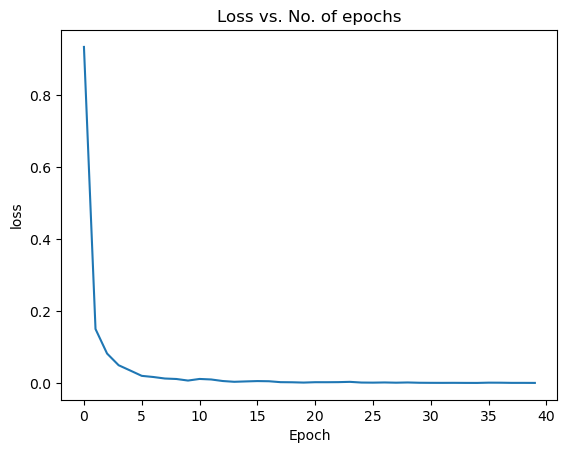

In [117]:
plt.plot(hist)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.show()

4


(4, np.True_)

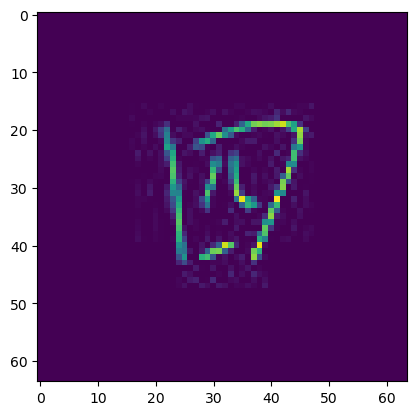

In [ ]:
def test_single_image(model, image, image_label, device):
    """
    Test a trained model on a single image.
    
    Args:
        model (nn.Module): The trained model.
        image (torch.Tensor): The input image, preprocessed.
        image_label (int): The true label of the image.
        device (torch.device): The device to perform computation on.
        
    Returns:
        pred_label (int): The predicted label.
        is_correct (bool): Whether the prediction matches the true label.
    """
    # Ensure model is in evaluation mode
    model.eval()
    
    # Move image and model to the specified device
    image = image.to(device)
    model = model.to(device)
    
    # Add batch dimension if necessary (model expects batches)
    if len(image.shape) == 3:  # Assuming the image is [C, H, W]
        image = image.unsqueeze(0)  # Add batch dimension -> [1, C, H, W]
    
    # Perform inference
    with torch.no_grad():
        logits = model(image)  # Forward pass
        pred_label = torch.argmax(logits, dim=1).item()  # Predicted label

    # Check if the prediction is correct
    is_correct = pred_label == image_label
    
    return pred_label, is_correct


testImg, testLabel = combined_testDataset[123]
print(testLabel)
plt.imshow(transforms.ToPILImage()(testImg))
test_single_image(best_model, testImg, testLabel, device)


# SVM

In [ ]:
import cupy as cp
from numba import cuda

# CuPy GPU test
cupy_array = cp.array([1, 2, 3])
print("CuPy array on GPU:", cupy_array)

# Transfer CuPy array to Numba
numba_array = cuda.to_device(cupy_array)
print("Numba array copied from CuPy:", numba_array.copy_to_host())


In [ ]:
import cuml
from cuml.svm import SVC
from cuml.metrics import accuracy_score
import numpy as np
import cupy as cp
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the images (replace with your transformations)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset (replace with your dataset)
trainDataset = combined_trainDataset  # Example dataset
testDataset = combined_testDataset

# Function to extract features with varying batch sizes
def extract_features(dataset, batch_size, model=None):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    features, labels = [], []
    
    for images, targets in loader:
        # If using a pre-trained model for feature extraction
        if model:
            images = images.to('cuda')  # Move to GPU if available
            with torch.no_grad():
                images = model(images).cpu()
        
        # Flatten each image into a 1D vector
        images = images.view(images.size(0), -1)  # (batch_size, num_features)
        features.append(images.numpy())
        labels.append(targets.numpy())
    
    # Convert to GPU arrays for cuML
    return cp.array(np.vstack(features)), cp.array(np.hstack(labels))

# Define SVM model (cuML)
model = SVC()

# Hyperparameter grid including batch size
hyperparams = {
    'batch_size': [32, 64, 128],       # Batch sizes to try
    'C': [0.1, 1, 10, 100],           # L2 regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],   # Influence of single training example
    'kernel': ['rbf', 'linear', 'sigmoid']  # Kernel types
}

# Custom grid search loop
best_score = 0
best_params = {}
for batch_size in hyperparams['batch_size']:
    # Extract features for this batch size
    X_train, y_train = extract_features(trainDataset, batch_size)
    X_test, y_test = extract_features(testDataset, batch_size)

    # Iterate through hyperparameter combinations
    for C in hyperparams['C']:
        for gamma in hyperparams['gamma']:
            for kernel in hyperparams['kernel']:
                # Train cuML SVM model
                model = SVC(C=C, gamma=gamma, kernel=kernel)
                model.fit(X_train, y_train)
                
                # Evaluate on the test set
                y_pred = model.predict(X_test)
                score = accuracy_score(y_test, y_pred)

                # Update best score and parameters
                if score > best_score:
                    best_score = score
                    best_params = {'C': C, 'gamma': gamma, 'kernel': kernel, 'batch_size': batch_size}

# Output the best parameters and score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Evaluate on the test data with the best batch size
X_train, y_train = extract_features(trainDataset, best_params['batch_size'])
X_test, y_test = extract_features(testDataset, best_params['batch_size'])

best_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate final metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred))


In [ ]:
import time

start_time = time.time()
# Run a single candidate through one cross-validation fold
model.fit(X_train, y_train)
print("Time for one fit:", time.time() - start_time)

# LeNet
## Define model

In [81]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_classes=15, dropout_rate=0.5):
        super(LeNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # 6 filters, 5x5 kernel
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 16 filters, 5x5 kernel
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling
        
        # Flattened size
        self.flattened_size = 16 * 13 * 13  # (16 channels, 13x13 spatial size after pooling)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 120)  # 120 hidden units
        self.dropout1 = nn.Dropout(p=dropout_rate)  # Dropout after fc1

        self.fc2 = nn.Linear(120, 84)  # 84 hidden units
        self.dropout2 = nn.Dropout(p=dropout_rate)  # Dropout after fc2

        self.fc3 = nn.Linear(84, num_classes)  # Output layer for 15 classes
    
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))  
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))  
        x = self.pool2(x)
        
        # Flatten the output tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))  
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))  
        x = self.dropout2(x)

        x = self.fc3(x)  # Output layer
        
        return x

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [64, 256],
    'dropout_rate': [0.3, 0.5],
    'optimizer': ['sgd', 'adam'],
    'num_epochs': [20, 40]
}


## Train model

In [ ]:
from sklearn.model_selection import ParameterGrid

# Function to train the model
def train_model(train_loader, model, criterion, optimizer, num_epochs):
    loss_history = []  # Initialize an empty list to store loss history

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            logits = model(X)
            loss = criterion(logits, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            epoch_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

        # Append loss for the current epoch to the loss history
        loss_history.append(epoch_loss / len(trainLoader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

    return loss_history

# Function to evaluate the model
def evaluate_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")
    return accuracy

# Function to perform grid search
def grid_search(param_grid):
    best_accuracy = 0.0
    best_params = None
    
    grid = ParameterGrid(param_grid)
    
    for params in grid:
        print(f"Training with params: {params}")
        
        # Create model, criterion, optimizer
        model = LeNet(dropout_rate=params['dropout_rate']).to(device)
        criterion = nn.CrossEntropyLoss()
        if params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        elif params['optimizer'] == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.99)
        
        # Create DataLoader with current batch size
        train_loader = DataLoader(combined_trainDataset, batch_size=params['batch_size'], shuffle=True)
        test_loader = DataLoader(combined_testDataset, batch_size=params['batch_size'], shuffle=False)
        
        # Train the model
        loss_history = train_model(train_loader, model, criterion, optimizer, params['num_epochs'])
        
        # Evaluate the model
        accuracy = evaluate_model(test_loader, model)
        
        # Update best model if needed
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            best_loss_history = loss_history
    
    print(f"Best accuracy: {best_accuracy}% with parameters: {best_params}")
    return best_params, best_accuracy, best_loss_history

# Run the grid search
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

best_params, best_accuracy, best_loss_history = grid_search(param_grid)

In [134]:
# Best accuracy: 96.63333333333334% with parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'num_epochs': 40, 'optimizer': 'sgd'}
# Best accuracy: 95.2% with parameters: {'batch_size': 256, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'num_epochs': 40, 'optimizer': 'adam'}
train_loader = DataLoader(combined_trainDataset, batch_size=64, shuffle=True)
test_loader = DataLoader(combined_testDataset, batch_size=64, shuffle=False)

model = LeNet(dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_history = train_model(train_loader, model, criterion, optimizer, num_epochs=40)

accuracy = evaluate_model(test_loader, model)

print(f"Test Accuracy: {accuracy}%")

Epoch [1/40], Loss: 1142.7942869663239
Epoch [2/40], Loss: 1085.8597402572632
Epoch [3/40], Loss: 786.7978168725967
Epoch [4/40], Loss: 627.517940402031
Epoch [5/40], Loss: 424.978766977787
Epoch [6/40], Loss: 292.19745087623596
Epoch [7/40], Loss: 218.80964314937592
Epoch [8/40], Loss: 183.6818604171276
Epoch [9/40], Loss: 153.53010710328817
Epoch [10/40], Loss: 125.18211135268211
Epoch [11/40], Loss: 114.58447190001607
Epoch [12/40], Loss: 116.7435450181365
Epoch [13/40], Loss: 91.26170724630356
Epoch [14/40], Loss: 83.88753770664334
Epoch [15/40], Loss: 74.12749739550054
Epoch [16/40], Loss: 71.07695708610117
Epoch [17/40], Loss: 65.21482994779944
Epoch [18/40], Loss: 67.36677142605186
Epoch [19/40], Loss: 67.43894605897367
Epoch [20/40], Loss: 59.686129081994295
Epoch [21/40], Loss: 51.77823169529438
Epoch [22/40], Loss: 54.48369804956019
Epoch [23/40], Loss: 50.46136267948896
Epoch [24/40], Loss: 44.78814752306789
Epoch [25/40], Loss: 44.40488314116374
Epoch [26/40], Loss: 39.9736

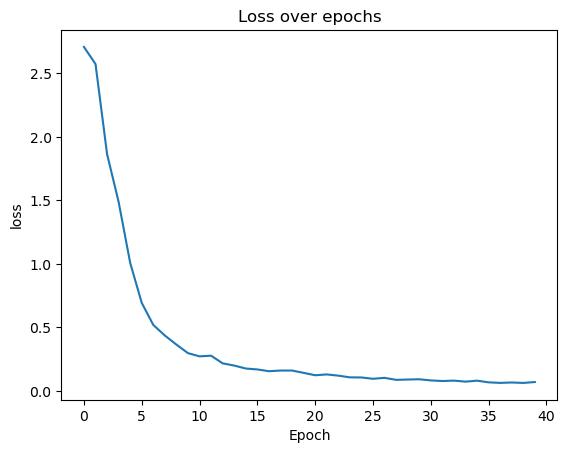

In [135]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss over epochs')
plt.show()